# importing all libraries

In [ ]:
import os
import re
import sys
import nltk
import itertools
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn import tree
from sklearn.svm import SVC
from joblib import dump, load
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential,Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding

# Reading the Dataset

In [ ]:
df = pd.read_csv('/content/Curriculum Vitae.csv')
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
11019,DotNet Developer,"Technical Skills â¢ Languages: C#, ASP .NET M..."
11020,DotNet Developer,Education Details \r\nJanuary 2014 Education ...
11021,DotNet Developer,"Technologies ASP.NET, MVC 3.0/4.0/5.0, Unit Te..."
11022,DotNet Developer,"Technical Skills CATEGORY SKILLS Language C, C..."


# List of all Categories

In [ ]:
for i in range(len(df['Category'].unique())):
    print(df['Category'].unique()[i])

Data Science
HR
Advocate
Arts
Web Designing
Mechanical Engineer
Sales
Health and fitness
Civil Engineer
Java Developer
Business Analyst
SAP Developer
Automation Testing
Electrical Engineering
Operations Manager
Python Developer
DevOps Engineer
Network Security Engineer
PMO
Database
Hadoop
ETL Developer
DotNet Developer
Blockchain
Testing


# Visualizing the data distribution in each category.

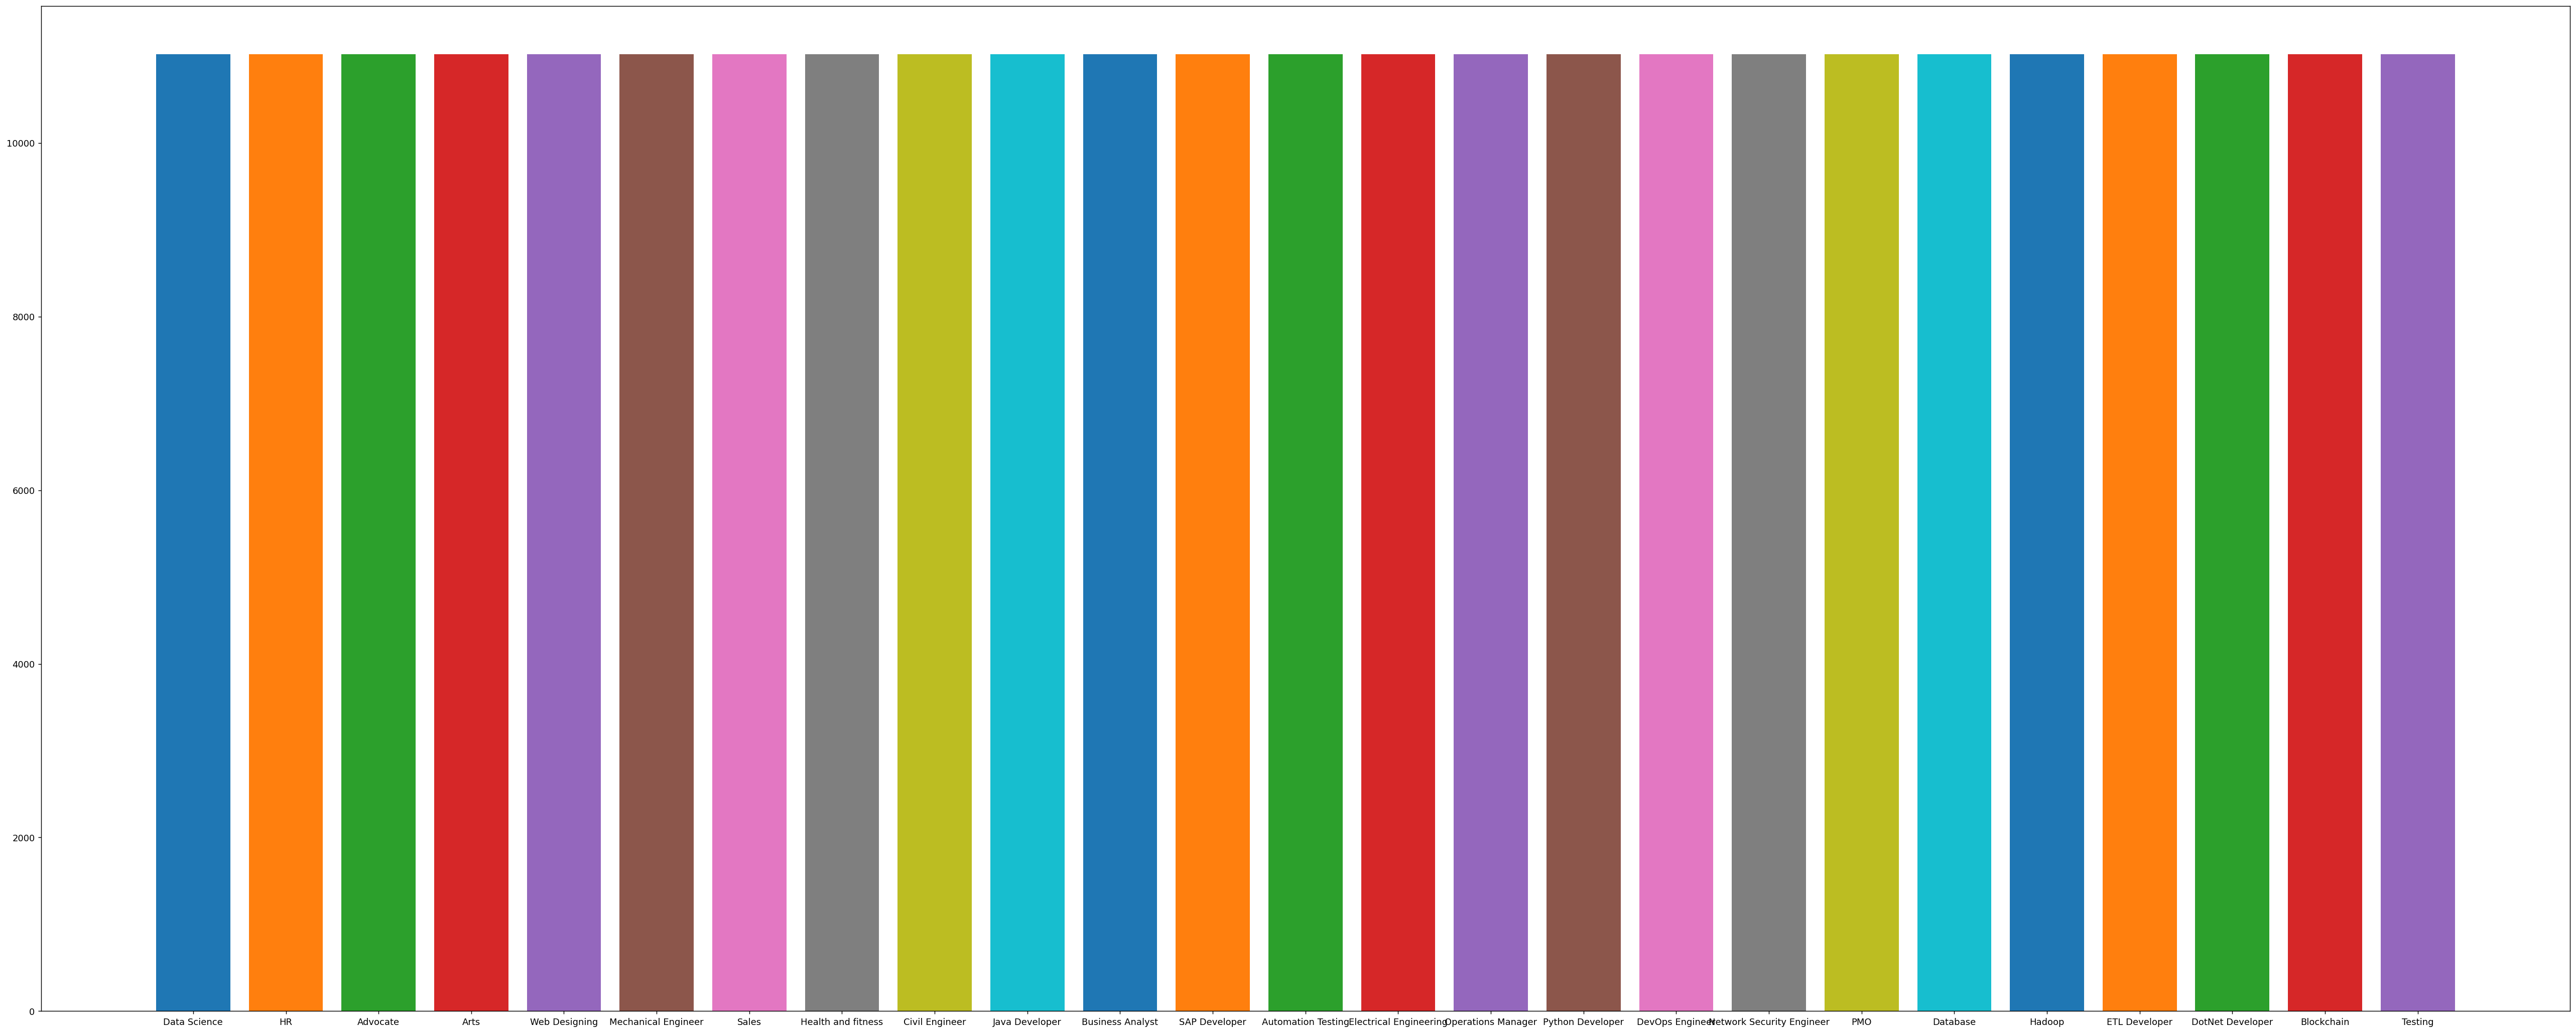

In [ ]:
plt.figure(figsize=(50, 20), dpi=130)
for i in range(len(df['Category'].unique())):
    plt.bar(df['Category'].unique()[i], len(df['Category']==df['Category'].unique()[i]))
plt.show()

# Visualizing most commonly used words in each type of Resumes

In [ ]:
a=[ 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r','BrBG_r', 'BuGn', 'BuGn_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'crest_r']
for label, cmap in zip(df['Category'].unique(), a):
    text = df.query("Category == @label")["Resume"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Resumes", size=20)
    plt.show()

# Visualizing the length disstribution of the content in the Resumes.

<ipython-input-38-4cde9b11b65b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length']).set_title('Resume length distribution')


Text(0.5, 1.0, 'Resume length distribution')

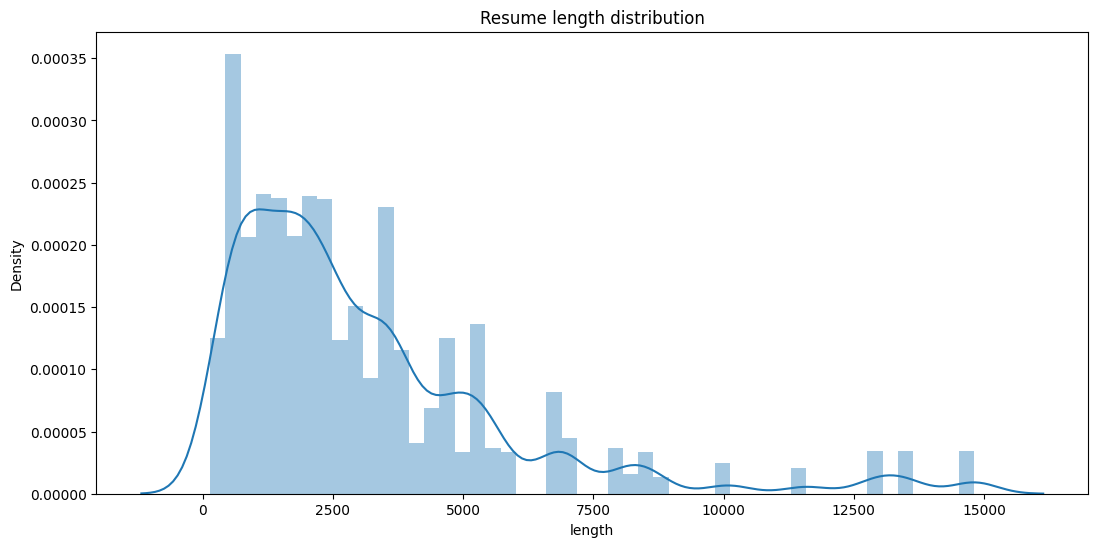

In [ ]:
df['length'] = df['Resume'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['length']).set_title('Resume length distribution')

# Summary of Length Distribution

In [ ]:
df['length'].describe()

count    11024.000000
mean      3150.527395
std       2832.771801
min        142.000000
25%       1236.000000
50%       2355.000000
75%       3911.000000
max      14816.000000
Name: length, dtype: float64

# Visualizing of number of words in each category of resume using boxplot

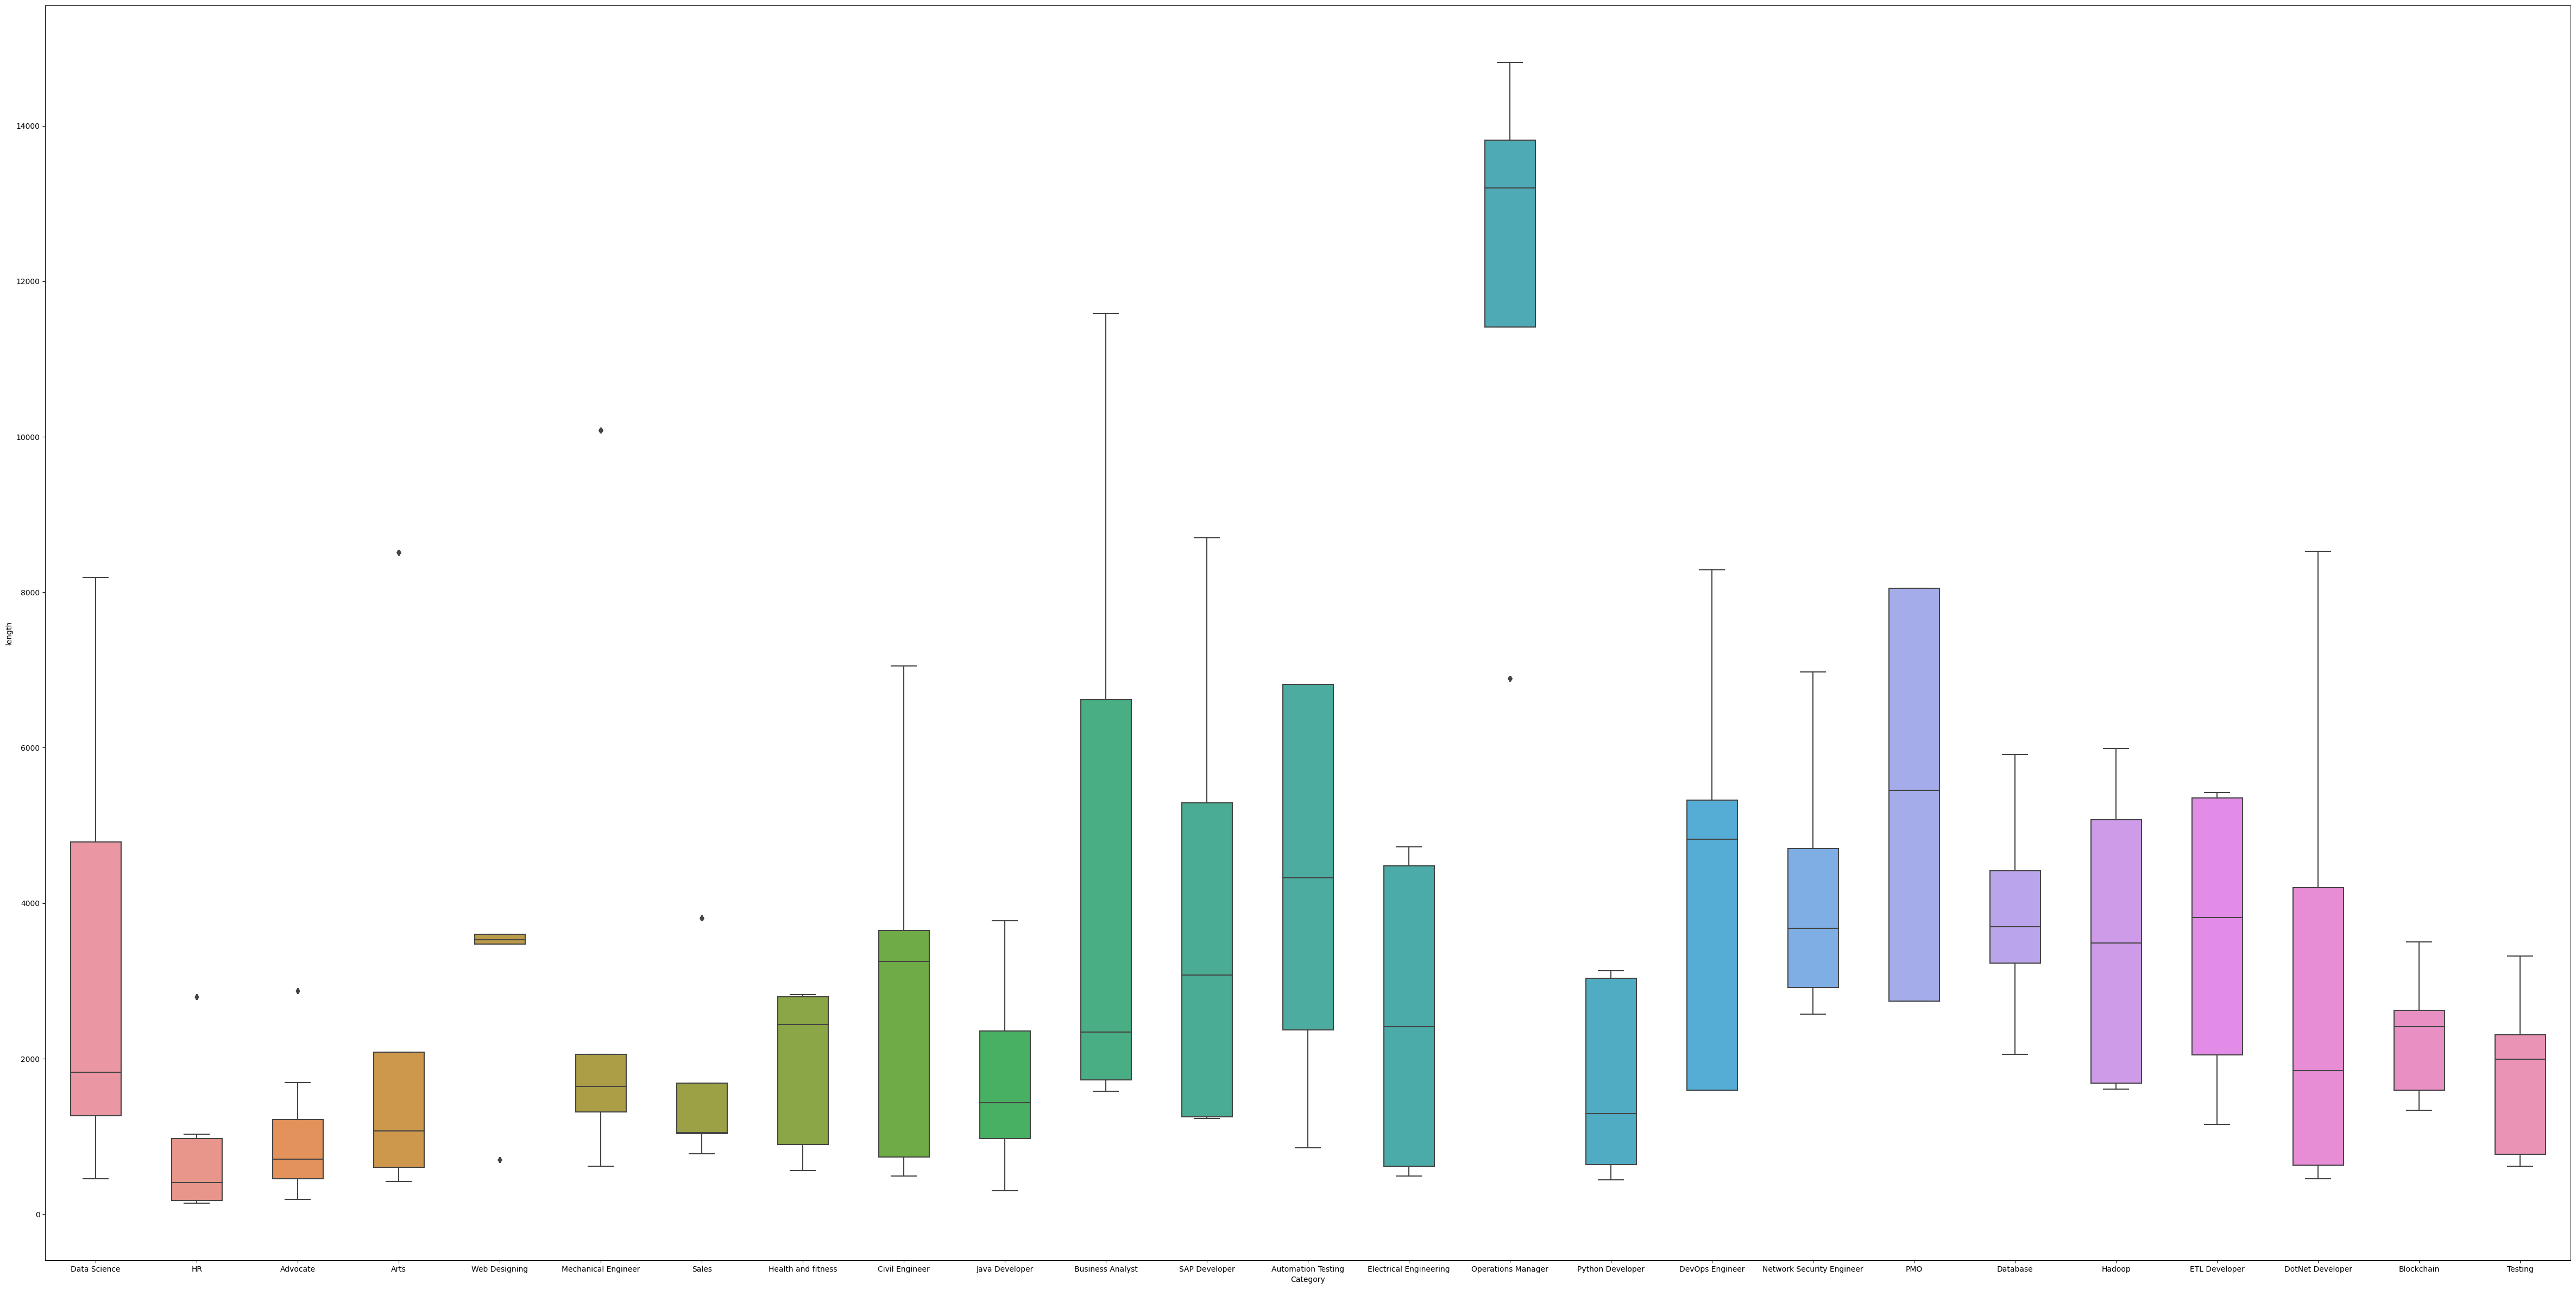

In [ ]:
plt.figure(figsize=(60,30))
sns.boxplot(data=df, x='Category', y='length', width=.5);

# Pre Processing

# Checking for missing data

In [ ]:
print(df.isnull().sum())

Category    0
Resume      0
length      0
dtype: int64


# Converting the data into lower case and removing words with small lengths

In [ ]:
df['Resume'] = df['Resume'].apply(lambda x:x.lower())
for i in range(len(df)):
    lw=[]
    for j in df['Resume'][i].split():
        if len(j)>=3:                  
            lw.append(j)
    df['Resume'][i]=" ".join(lw)

<ipython-input-42-79d6dd5744c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Resume'][i]=" ".join(lw)


# removing punctuations

In [ ]:
ps = list(";?.:!,")
df['Resume'] = df['Resume']

for p in ps:   
    df['Resume'] = df['Resume'].str.replace(p, '')

<ipython-input-43-34aee2d96334>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Resume'] = df['Resume'].str.replace(p, '')


# Removing '\n' and '\t', extra spaces, quoting text and progressive pronouns

In [ ]:
df['Resume'] = df['Resume'].str.replace("    ", " ")
df['Resume'] = df['Resume'].str.replace('"', '')
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\t', ' '))
df['Resume'] = df['Resume'].str.replace("'s", "")
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\n', ' '))

# Applying Lemmatization

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
wl = WordNetLemmatizer()
nr = len(df)
lis = []
for r in range(0, nr):
    ll = []
    t = df.loc[r]['Resume']
    tw = str(t).split(" ")
    for w in tw:
        ll.append(wl.lemmatize(w, pos="v"))
    lt = " ".join(ll)
    lis.append(lt)

In [ ]:
df['Resume'] = lis

# Removing Stop-words

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
sw = list(stopwords.words('english'))
for s in sw:
    rs = r"\b" + s + r"\b"
    df['Resume'] = df['Resume'].str.replace(rs, '')

<ipython-input-49-b2a2537f2ca1>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Resume'] = df['Resume'].str.replace(rs, '')


# Visualizing most commonly used words in Resumes after applying NLP techniques 

In [ ]:
a=[ 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r','BrBG_r', 'BuGn', 'BuGn_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'crest_r']
for label, cmap in zip(df['Category'].unique(), a):
    text = df.query("Category == @label")["Resume"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Resumes", size=20)
    plt.show()

# Data Preparation for Training and Testing

# Encoding Labels

In [ ]:
df['Category'] = LabelEncoder().fit_transform(df['Category'])

# Using Bag of Words approach for converting the content in resumes into vector form

In [ ]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(df['Resume']).toarray()
y = df['Category']

# Splitting the Data using Stratified split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Greens):
    plt.figure(figsize=(50, 20), dpi=130)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Using AdaBoost Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  0.2971584038694075


['ada.joblib']

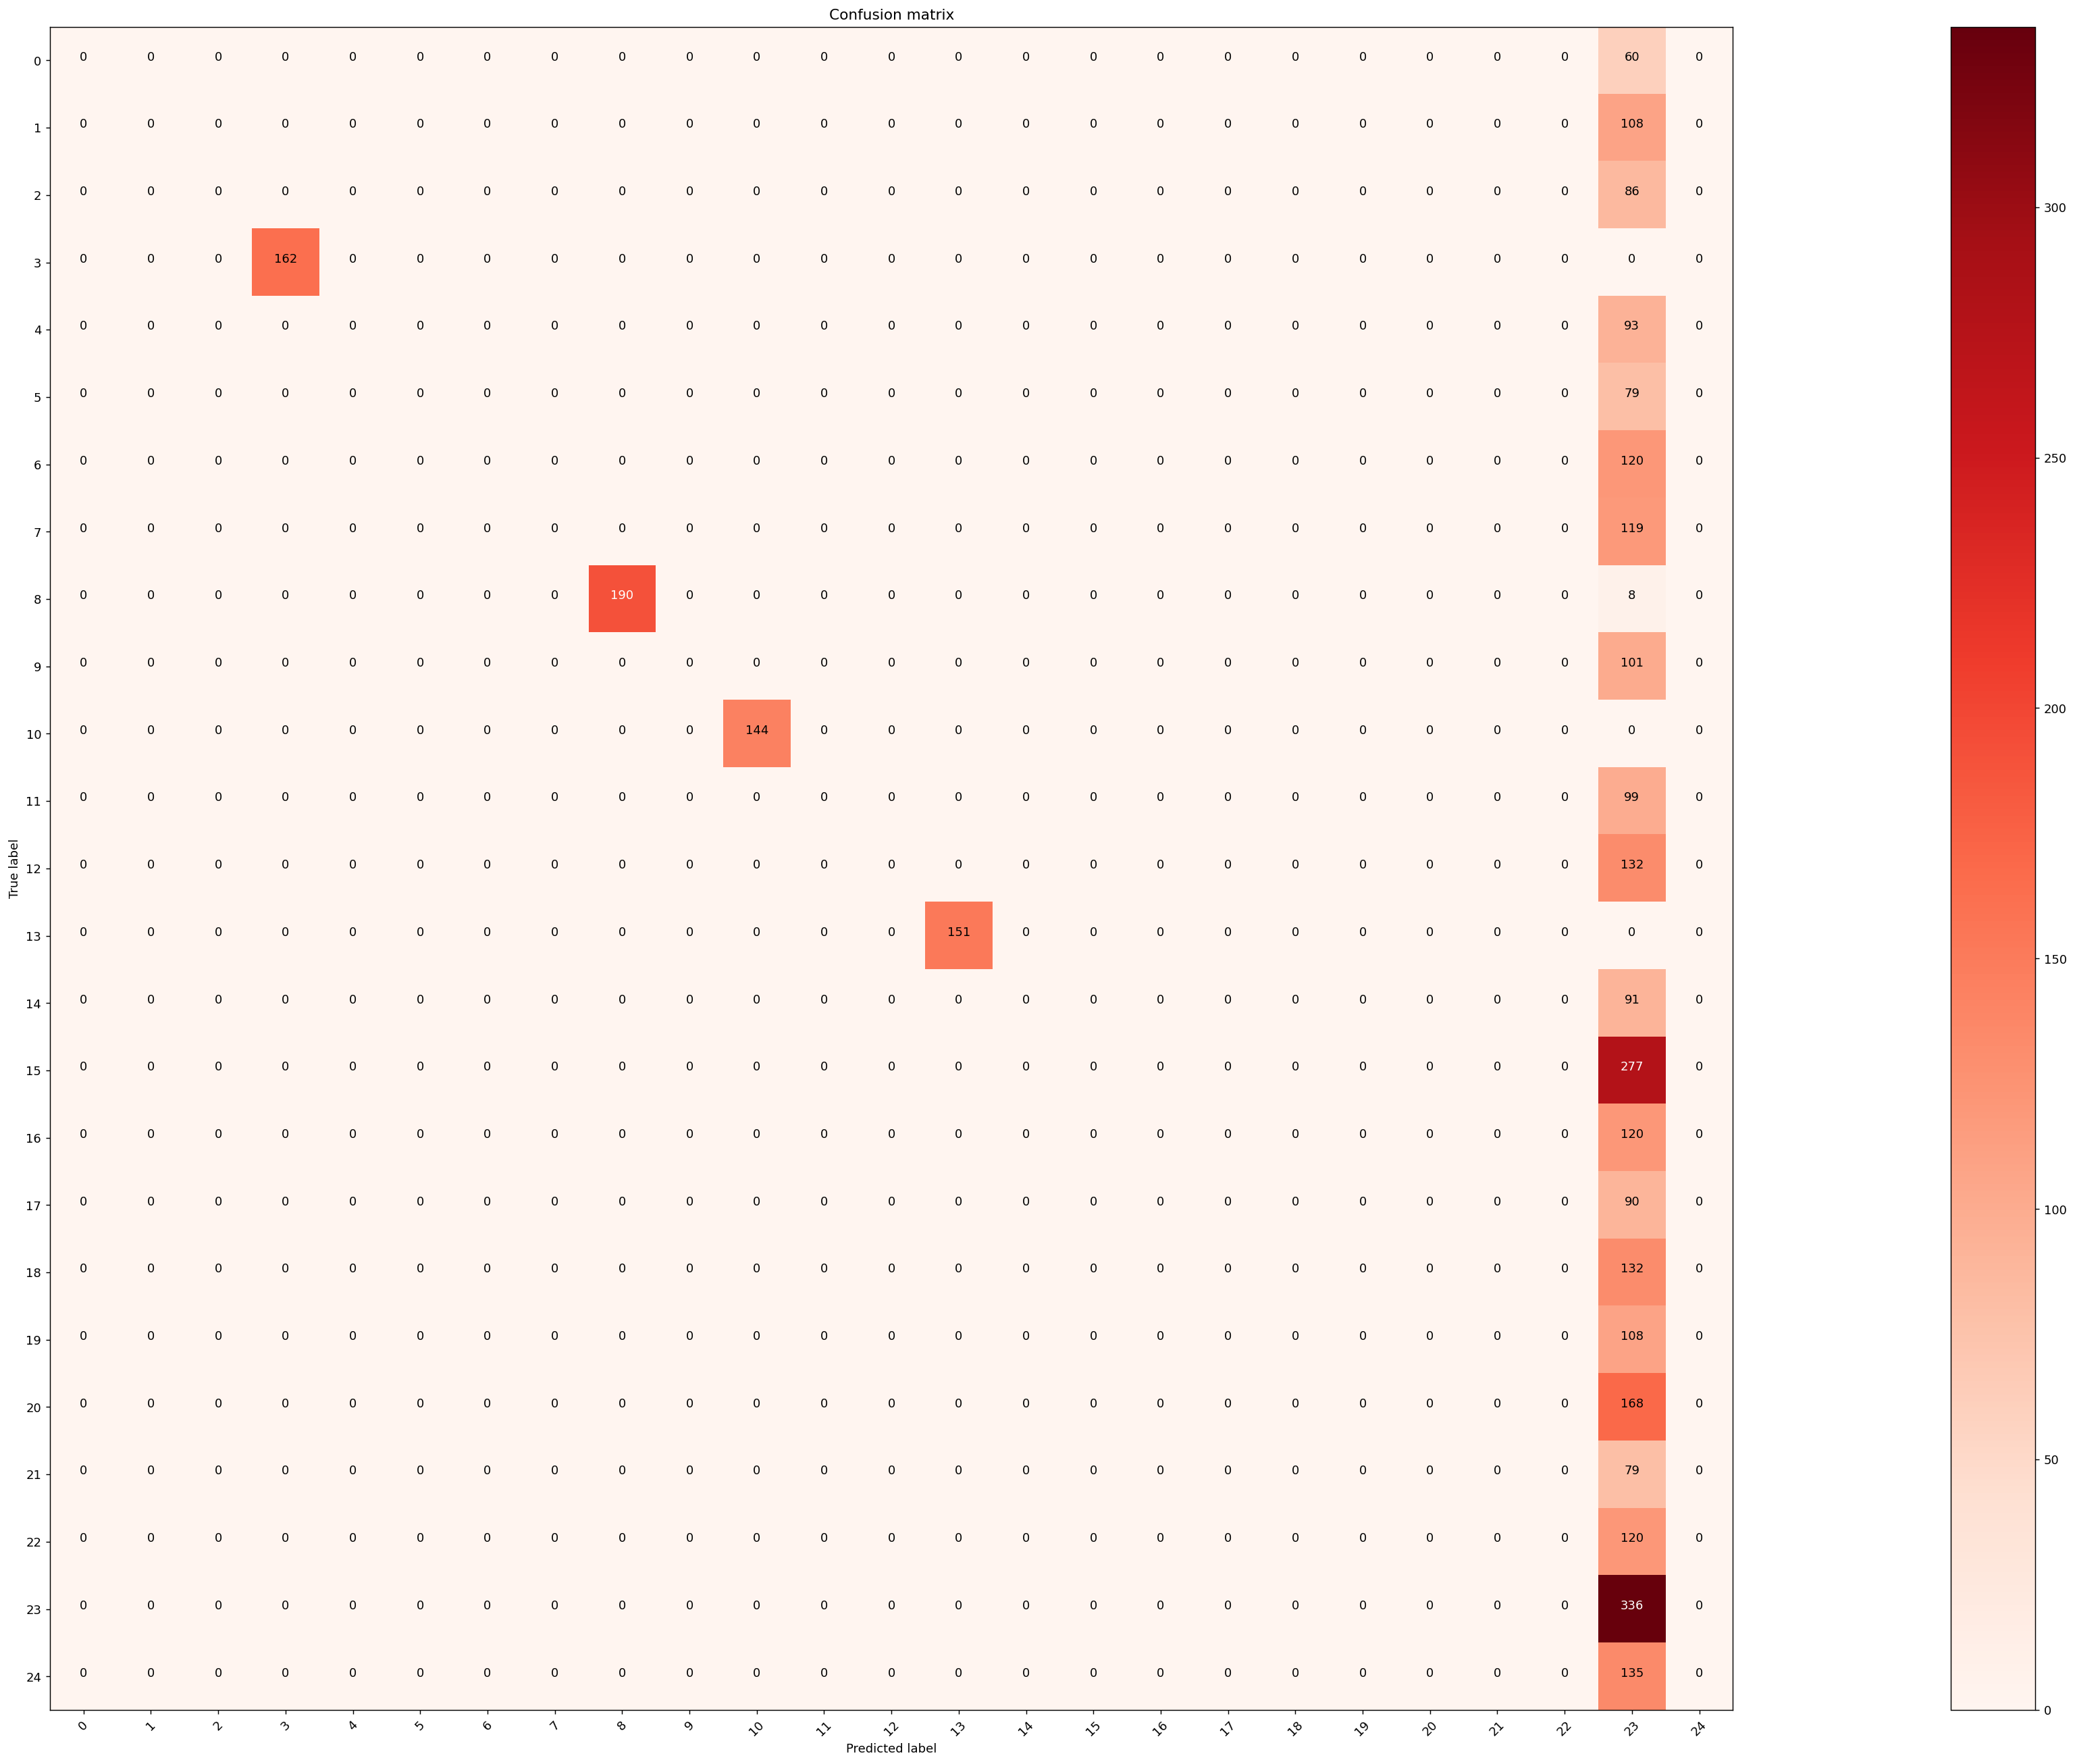

In [ ]:
clf = AdaBoostClassifier(n_estimators=60)
clf = clf.fit(X_train, y_train)
yp = clf.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
CM = confusion_matrix(y_test, yp)
plot_confusion_matrix(CM, classes = range(25),cmap=plt.cm.Reds)
dump(clf, 'ada.joblib') 

# Using KNeighbors Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  1.0


['knei.joblib']

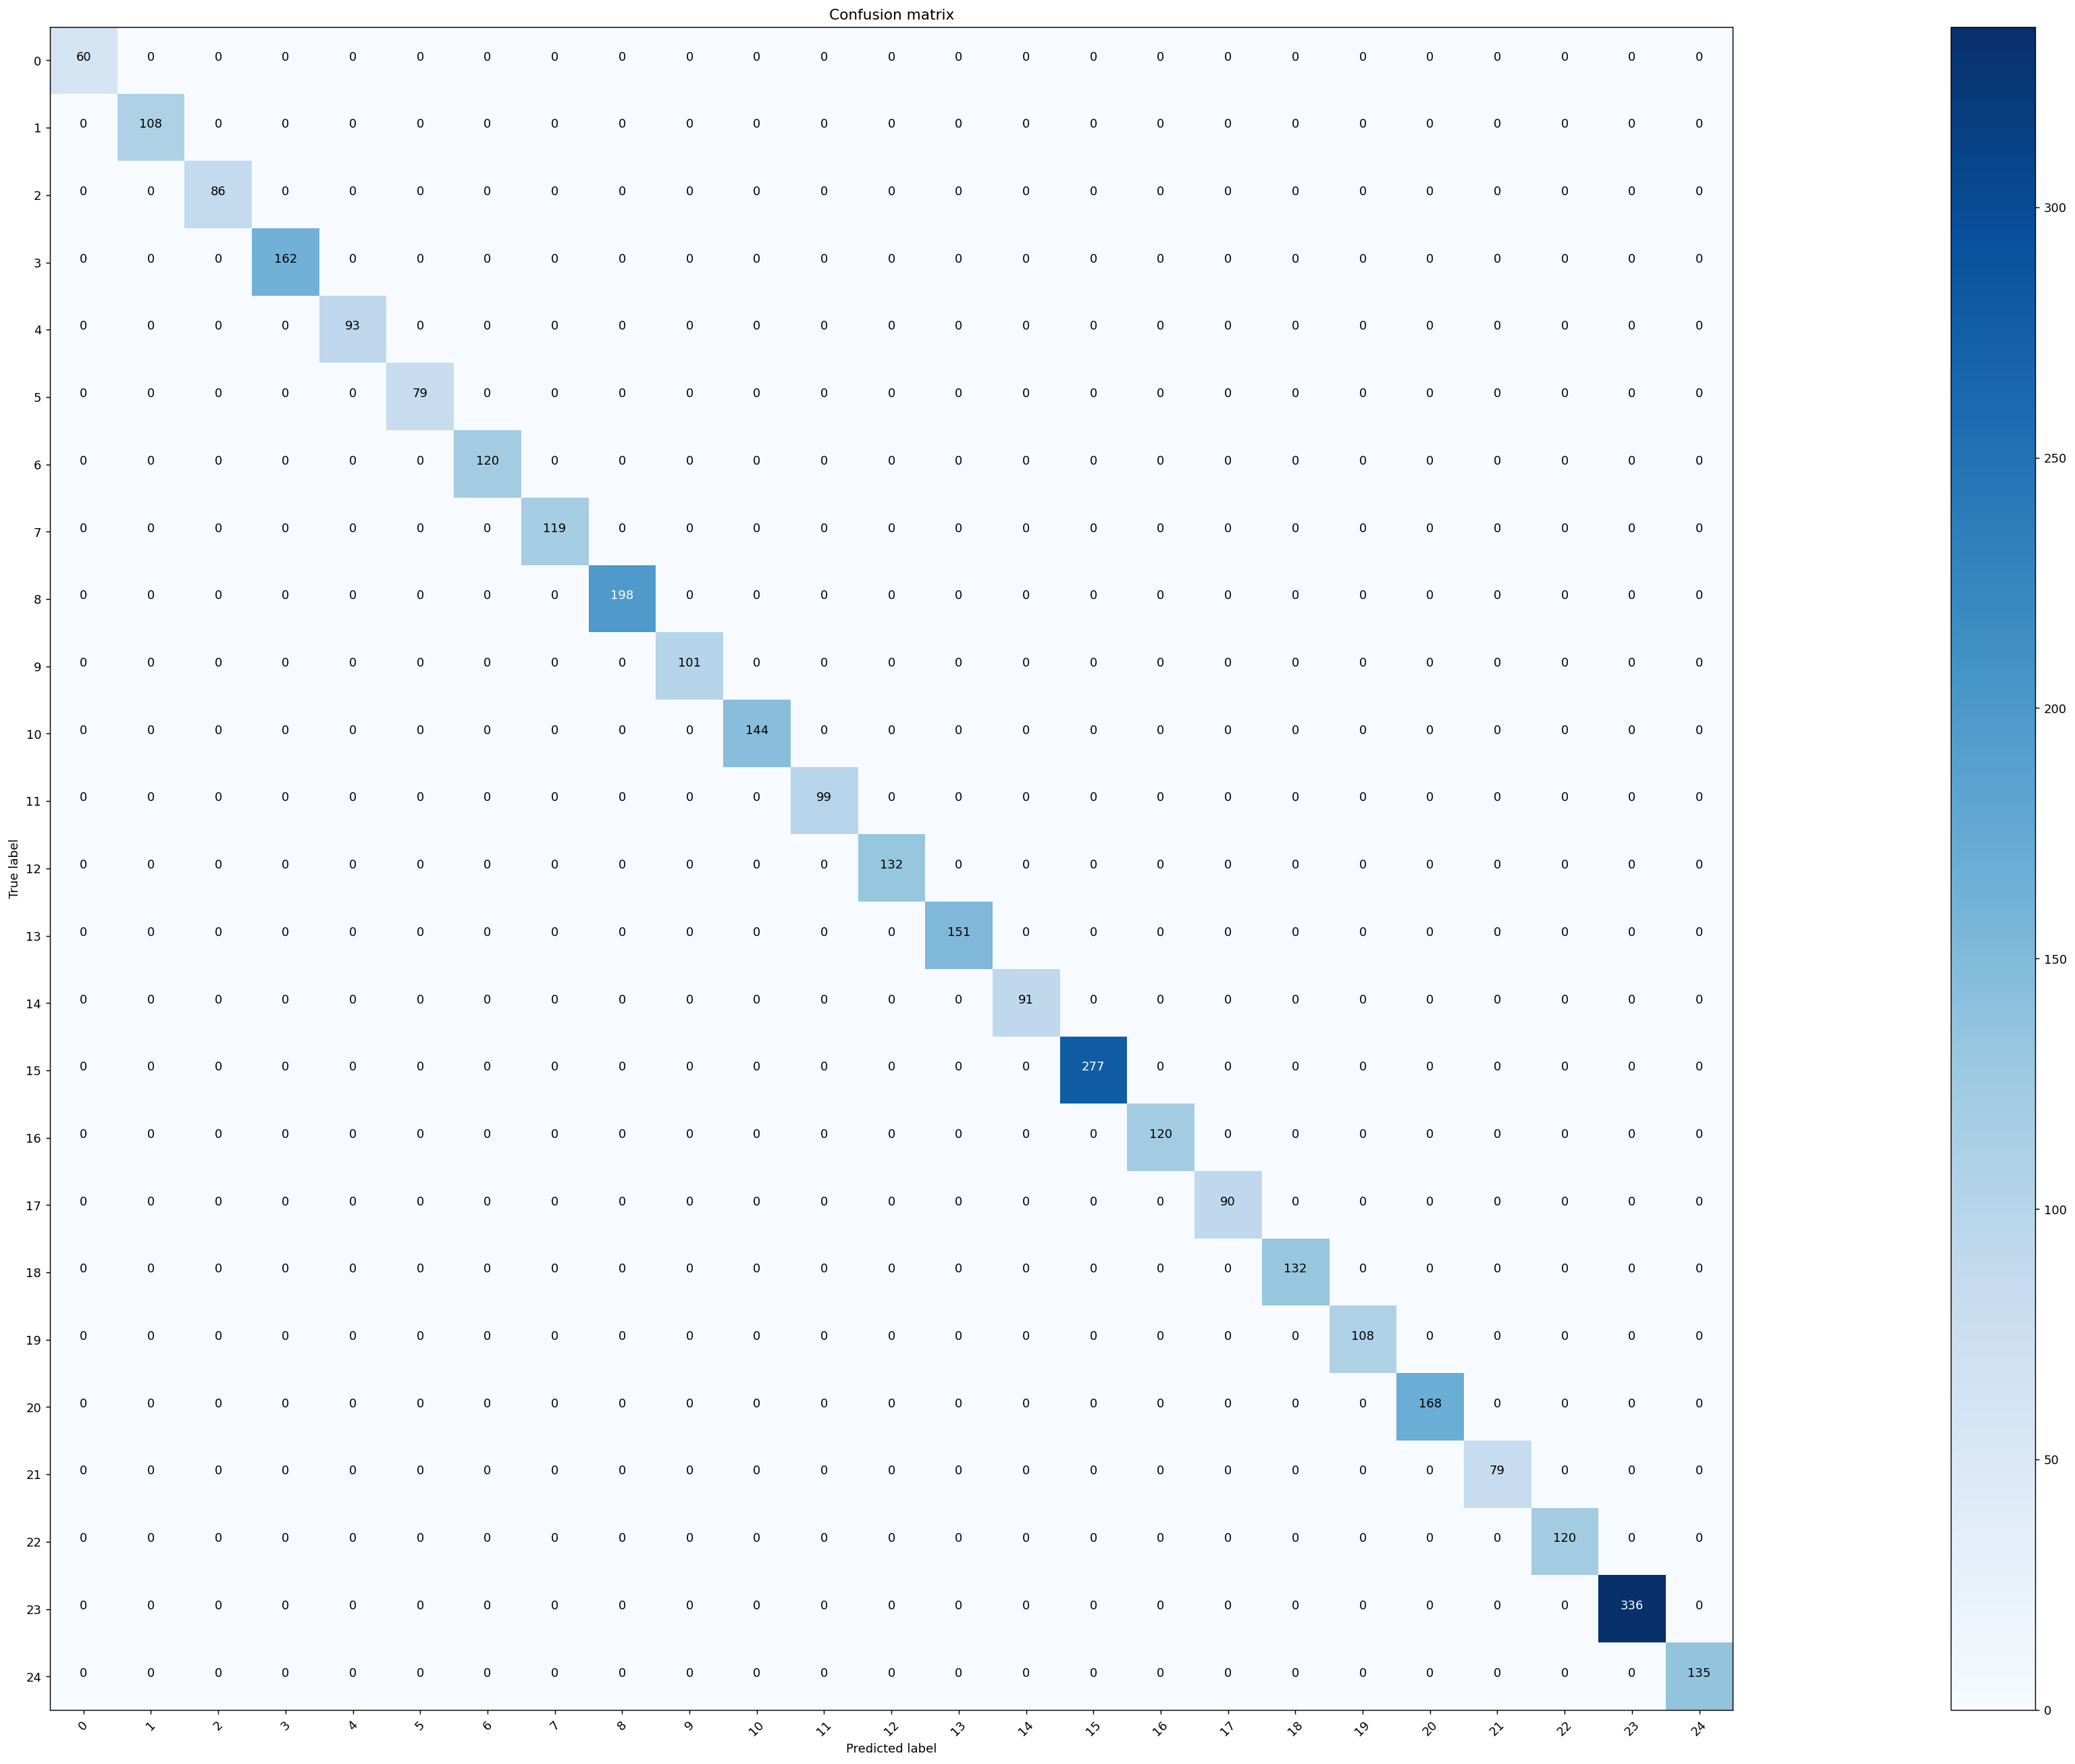

In [ ]:
clf = KNeighborsClassifier(n_neighbors=7)
clf = clf.fit(X_train, y_train)
yp = clf.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
CM = confusion_matrix(y_test, yp)
plot_confusion_matrix(CM, classes = range(25),cmap=plt.cm.Blues)
dump(clf, 'knei.joblib') 

# Using Decision tree as the Model and printing evaluating it using confusion matrix

accuracy is:  1.0


['DT.joblib']

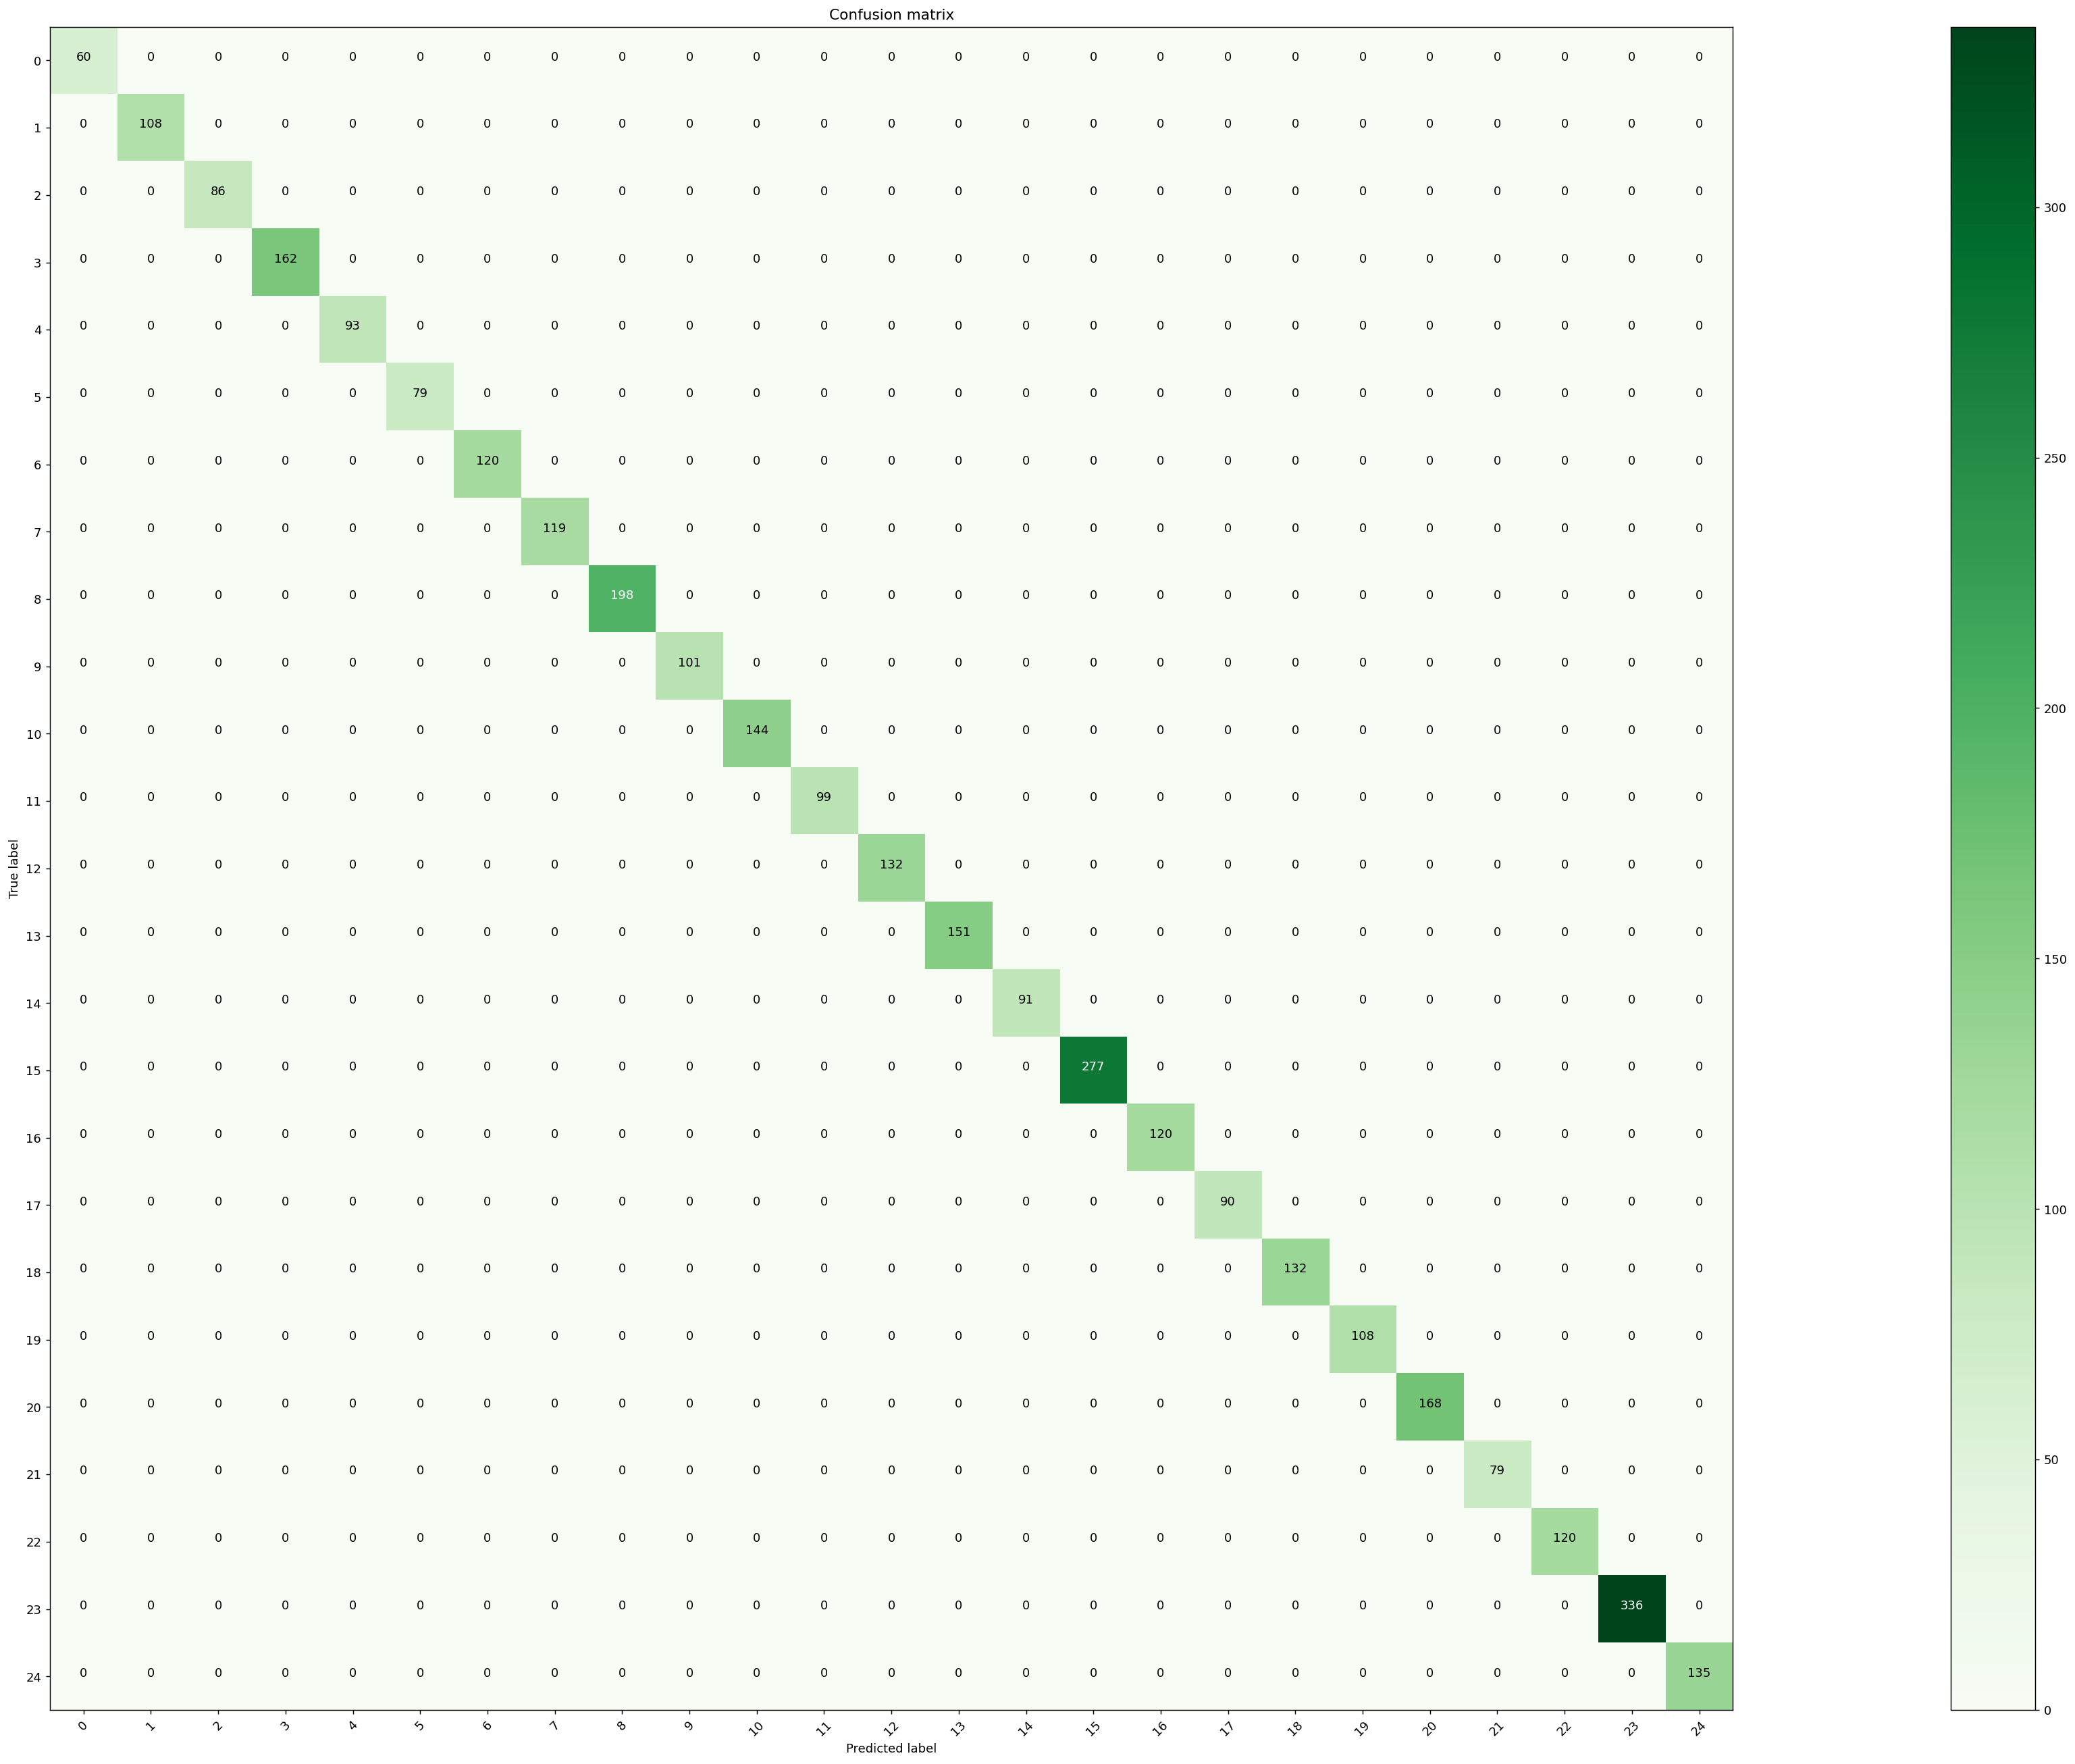

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
yp = clf.predict(X_test)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
CM = confusion_matrix(y_test, yp)
plot_confusion_matrix(CM, classes = range(25))
dump(clf, 'DT.joblib') 

# Turning encoded lables into Categorical format

In [ ]:
y_train=to_categorical(y_train, num_classes = 25, dtype='float32')
y_test=to_categorical(y_test, num_classes = 25, dtype='float32')

In [ ]:
from keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding 
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

# Building a 1D CNN model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=232337, output_dim=100, input_length=X_train.shape[1]))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPool1D(3))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size = 64, epochs=15, validation_data = (X_test,y_test), verbose=1)

Epoch 1/15
121/121 [==============================] - 304s 3s/step - loss: 0.0313 - accuracy: 0.8749 - val_loss: 0.0118 - val_accuracy: 0.9764
Epoch 2/15
121/121 [==============================] - 305s 3s/step - loss: 0.0292 - accuracy: 0.8913 - val_loss: 0.0105 - val_accuracy: 0.9855
Epoch 3/15
121/121 [==============================] - 304s 3s/step - loss: 0.0264 - accuracy: 0.8997 - val_loss: 0.0083 - val_accuracy: 0.9843
Epoch 4/15
121/121 [==============================] - 305s 3s/step - loss: 0.0241 - accuracy: 0.9114 - val_loss: 0.0074 - val_accuracy: 0.9982
Epoch 5/15
121/121 [==============================] - 288s 2s/step - loss: 0.0222 - accuracy: 0.9213 - val_loss: 0.0077 - val_accuracy: 0.9882
Epoch 6/15
121/121 [==============================] - 309s 3s/step - loss: 0.0203 - accuracy: 0.9318 - val_loss: 0.0064 - val_accuracy: 0.9879
Epoch 7/15
121/121 [==============================] - 287s 2s/step - loss: 0.0194 - accuracy: 0.9323 - val_loss: 0.0051 - val_accuracy: 0.9982

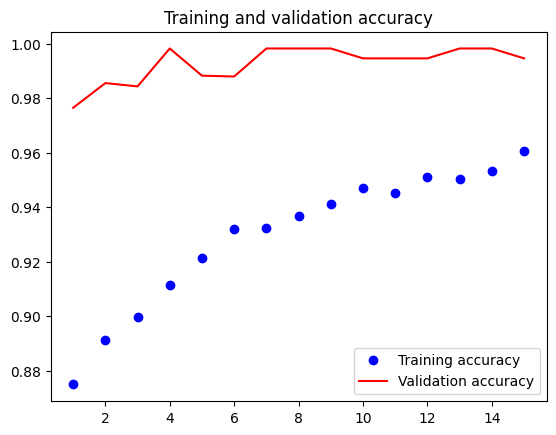

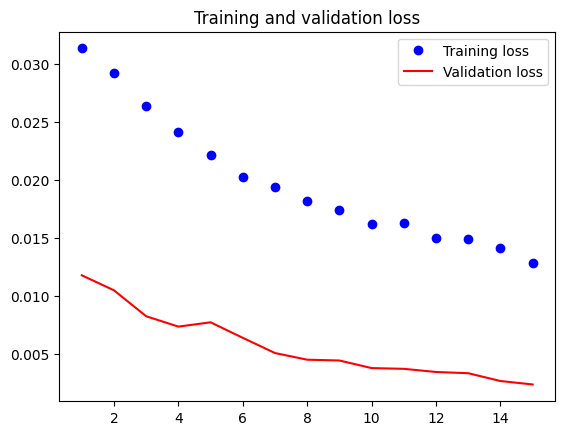

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
a= model.evaluate(X_test,y_test)
print("accuracy is: ",a[1])

104/104 [==============================] - 23s 216ms/step - loss: 0.0024 - accuracy: 0.9946
accuracy is:  0.9945586323738098


In [ ]:
model.save('cnn.h5')